In [1]:
# https://platform.openai.com/docs/tutorials/web-qa-embeddings

In [10]:
import requests
import re
import tiktoken
import pandas as pd
import os
import openai
import requests
from bs4 import BeautifulSoup
import time
import random

openai.api_key = KEY

In [3]:
url = "https://www.gov.uk/api/content/foreign-travel-advice"
base_url = "https://www.gov.uk/api/content"

In [4]:
# A function to extract the list of individual country api urls
def url_list(url):
    response = requests.get(url).json()
    list_of_urls = [i["base_path"] for i in response["links"]["children"]]
    return list_of_urls

In [44]:
# functions to clean text from api
def remove_text_between_angle_brackets(input_string):
    pattern = r'<.*?>'  # This pattern matches everything between angle brackets
    result = re.sub(pattern, '', input_string)
    return result

def remove_newlines(serie):
    serie = serie.replace('\n', ' ')
    serie = serie.replace('\\n', ' ')
    serie = serie.replace('  ', ' ')
    serie = serie.replace('   ', ' ')
    return serie

def clean_text(serie):
    serie = serie.replace('\n', ' ')
    serie = serie.replace('\\n', ' ')
    serie = serie.replace('\r', ' ')
    serie = serie.split()
    serie = ' '.join(serie)
    if len(serie.split("Climate Trip ideas")) == 1:
        serie = serie.split("Climate Trip ideas")[0].split("Why travel with")[0].strip()
    else:
        serie = serie.split("Climate Trip ideas")[1].split("Why travel with")[0].strip()
    serie = re.sub(r'Creating tailor-made.*?Request a brochure', '', serie)
    return serie

In [6]:
# a function to extract the text from each country on the fco government advice page and save them into individual text files

def api_crawl():
    # get a list of the api urls
    api_url_list = url_list(url)

    # Create a directory to store the text files
    if not os.path.exists("raw_data/"):
            os.mkdir("raw_data/")

    if not os.path.exists("raw_data/"):
            os.mkdir("raw_data/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # iterate through url list to get all the text for every country
    for country in api_url_list:                                                 
        

        # Save text from the url to a country.txt file
        with open('raw_data/'+ country[23:] + ".txt", "w", encoding="UTF-8") as f:
            
            # create api url
            country_url = base_url + country
            
            # make request to api
            response = requests.get(country_url).json()
            
            # extract and clean text for the country
            text = ''
            for part in response["details"]["parts"]:
                part = remove_text_between_angle_brackets(part['body'])
                part = remove_newlines(part)
                text+=part

            # write the text to the file in the text directory
            f.write(text)

api_crawl()

In [11]:
# a function to extract the list of countries from the UK Audley website

def web_crawl_destinations():
    # URL of the website to scrape
    url = "https://www.audleytravel.com/destinations"
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
    }
    
    destination_response = requests.get(url, headers=headers)
    
    # Parse the HTML content using BeautifulSoup
    destination_soup = BeautifulSoup(destination_response.content, "html.parser")

    article_divs = destination_soup.find_all("ul", class_="dest-list__links")

    country_links = []
    
    # Iterate through the found <div> elements
    for div in article_divs:
        anchor_tags = div.find_all("a")
        # Iterate through the <a> elements
        for anchor in anchor_tags:
            href = anchor.get("href")  # Extract href attribute
            country_links.append(href)

    # remove the duplicates in the list
    country_links = list(dict.fromkeys(country_links))
    
    time.sleep(1)
    
    return country_links

countries = web_crawl_destinations()

In [45]:
# a function to extract the text from each page and save it to a text file

def web_crawl_text(countries):

    # header used for scraping
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
    }

    for country in countries:
        
        url = f"https://www.audleytravel.com{country}/best-time-to-visit"

        country = country.replace("/","_")
        
        # Save text from the url to a country.txt file
        with open('raw_data/' + country[1:] + "_best_time" + ".txt", "w", encoding="UTF-8") as f:
            
            print(country[1:])
            
            response = requests.get(url, headers=headers)
        
            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(response.content, "html.parser")

            if "Page not found!" in soup.get_text():    # check if its a valid page, if not create new url. down to slight differences in the urls
                print(f"{country[1:]} page has a different format")
                time.sleep(random.randint(2, 5)) # sleep
                url = f"https://www.audleytravel.com{country.replace('_','/')}/best-time-to-visit{country.replace('_','-')}" # new url
                if country[1:] == "usa_hawaii":                                        # US state with a stand alone url
                    url = "https://www.audleytravel.com/usa/hawaii/best-time-to-visit-hawaii"
                response = requests.get(url, headers=headers) 
                soup = BeautifulSoup(response.content, "html.parser") 
                
    
            # extract and clean text
            text = clean_text(soup.get_text())
    
            # write the text to the file in the text directory
            f.write(text)
            time.sleep(random.randint(2, 5))


web_crawl_text(countries[55:])

paraguay
peru
the-philippines
portugal
rwanda
saint-kitts-and-nevis
saint-lucia
samoa
the-seychelles
south-africa
south-korea
spain
sri-lanka
st-vincent-and-the-grenadines
tanzania
thailand
turkey
uganda
uruguay
usa
vietnam
zambia
zanzibar-archipelago
zimbabwe


In [46]:
#create a df from the stored text files

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("raw_data/"):

    # Open the file and read the text
    with open("raw_data/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # append text to list.
        texts.append((file[:-4], text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# # Set the text column to be the raw text with the newlines removed
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,curacao,"Before you travel, check the ‘Entry requireme..."
1,andorra,"The Foreign, Commonwealth &amp; Development Of..."
2,haiti,"The Foreign, Commonwealth &amp; Development Of..."
3,namibia_best_time,The best time to visit Namibia is from July to...
4,finland,"The Foreign, Commonwealth &amp; Development Of..."


<Axes: >

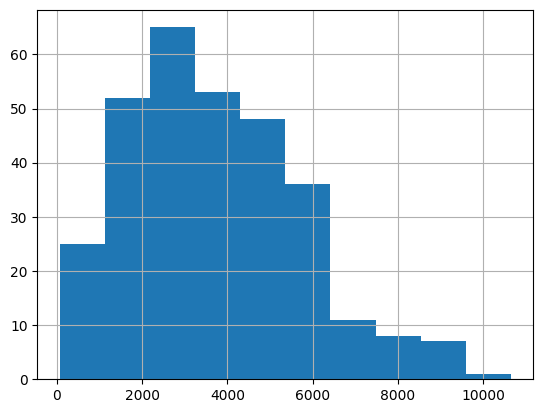

In [47]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [48]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

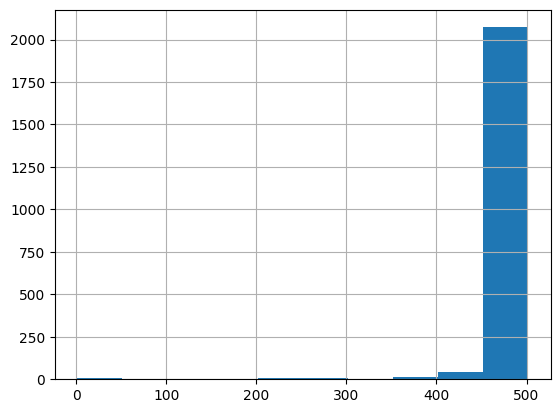

In [49]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [50]:


df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,"Before you travel, check the ‘Entry requireme...",492,"[0.011368561536073685, 0.008990953676402569, 0..."
1,Plan ahead and make sure you: can access money...,477,"[0.02092743292450905, 0.009720101952552795, 0...."
2,"However, the International Air Transport Assoc...",500,"[0.006420987192541361, -0.004806826822459698, ..."
3,If you’re transiting through Curaçao Transitin...,497,"[0.02678772248327732, 0.015563013963401318, 0...."
4,"While travel can be enjoyable, it can sometime...",491,"[0.010565687902271748, 0.011830685660243034, 0..."


In [51]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,"Before you travel, check the ‘Entry requireme...",492,"[0.011368561536073685, 0.008990953676402569, 0..."
1,Plan ahead and make sure you: can access money...,477,"[0.02092743292450905, 0.009720101952552795, 0...."
2,"However, the International Air Transport Assoc...",500,"[0.006420987192541361, -0.004806826822459698, ..."
3,If you’re transiting through Curaçao Transitin...,497,"[0.02678772248327732, 0.015563013963401318, 0...."
4,"While travel can be enjoyable, it can sometime...",491,"[0.010565687902271748, 0.011830685660243034, 0..."


In [52]:
def create_context(
    question, df, max_len=1800, size="ada"
    ):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [53]:
def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [75]:
answer_question(df, question="Whens the best time to visit the USA?")

'The best time to visit the USA depends on which region you are visiting. For the northern USA, the best time to visit is between May and June. For the southern USA, the best time to visit is in spring (March-May), or autumn (September-November).'

In [76]:
answer_question(df, question="Do i need a visa?")

'It depends on your nationality and the purpose of your travel. You may need an Electronic System for Travel Authorization (ESTA) visa waiver or a visa to enter or transit the USA as a visitor.'

In [77]:
answer_question(df, question="Is it safe to travel?")

"I don't know."

In [81]:
# no menory Q&A

question1 = "Whens the best time to visit the india?"
question2 = "Do i need a visa?"

answer1 = answer_question(df, question=question1)
answer2 = answer_question(df, question=question2)

print(question1)
print(answer1)
print(question2)
print(answer2)

Whens the best time to visit the india?
The best time to visit India is between October and March, when the weather is more likely to be warm, sunny, and dry.
Do i need a visa?
It depends on your nationality and the purpose of your travel. You may need an Electronic System for Travel Authorization (ESTA) visa waiver or a visa to enter or transit the USA as a visitor.


In [79]:
# full chain memory
memory = ""
question1 = "Whens the best time to visit the USA?"
memory += question1 + " "
answer1 = answer_question(df, question=memory)
memory += answer1 + " "
question2 = "Do i need a visa?"
memory += question2 + " "
answer2 = answer_question(df, question=memory)

print(question1)
print(answer1)
print(question2)
print(answer2)

Whens the best time to visit the USA?
The best time to visit the USA depends on which region you are visiting. The best time to visit the northern USA is between May and June, while the best time to visit the southern USA is in spring (March-May), or autumn (September-November).
Do i need a visa?
I don't know.


In [80]:
memory

'Whens the best time to visit the USA? The best time to visit the USA depends on which region you are visiting. The best time to visit the northern USA is between May and June, while the best time to visit the southern USA is in spring (March-May), or autumn (September-November).Do i need a visa? '